In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
apple_stock = pd.read_csv("apple_stock.csv")
df = apple_stock.copy()

### Exploration Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2475 non-null   object 
 1   Open       2475 non-null   float64
 2   High       2475 non-null   float64
 3   Low        2475 non-null   float64
 4   Close      2475 non-null   float64
 5   Adj Close  2475 non-null   float64
 6   Volume     2475 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 135.5+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2.475000e+03
mean,76.004968,76.845661,75.213720,76.064199,74.097124,1.380565e+08
std,54.739063,55.389713,54.134658,54.787600,55.248195,8.399674e+07
min,17.684999,17.911785,17.626785,17.849285,15.648315,3.145820e+07
25%,29.592500,29.841249,29.371249,29.707500,27.131330,8.300500e+07
50%,47.507500,47.967499,47.267502,47.599998,45.507229,1.134760e+08
75%,132.145004,133.680000,130.495003,132.029999,130.403320,1.682138e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.065523e+09


In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Graphing

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.day_name() 

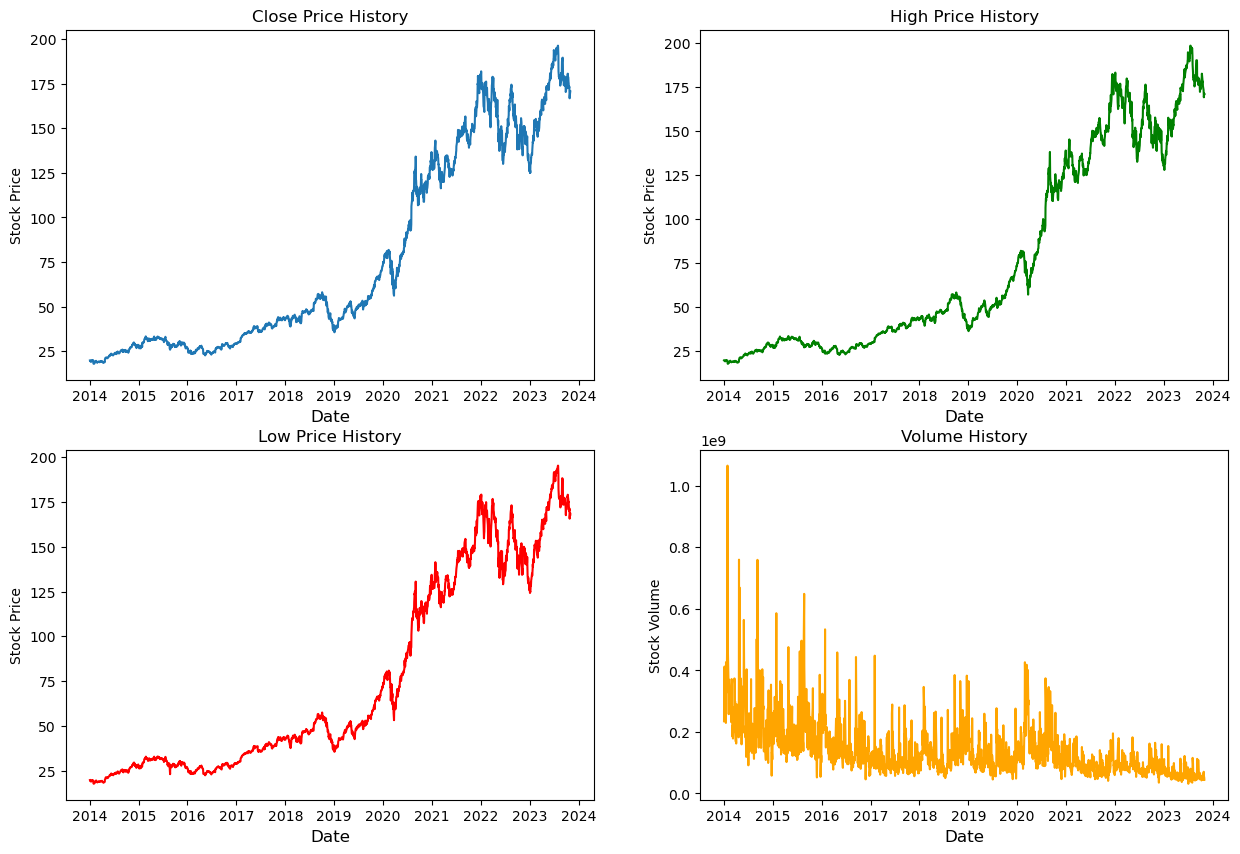

In [8]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(df['Date'], df['Close'])
axes[0, 0].set_xlabel("Date", fontsize=12)
axes[0, 0].set_ylabel("Stock Price")
axes[0, 0].set_title("Close Price History")

axes[0, 1].plot(df['Date'], df['High'], color="green")
axes[0, 1].set_xlabel("Date", fontsize=12)
axes[0, 1].set_ylabel("Stock Price")
axes[0, 1].set_title("High Price History")

axes[1, 0].plot(df['Date'], df['Low'], color="red")
axes[1, 0].set_xlabel("Date", fontsize=12)
axes[1, 0].set_ylabel("Stock Price")
axes[1, 0].set_title("Low Price History")

axes[1, 1].plot(df['Date'], df['Volume'], color="orange")
axes[1, 1].set_xlabel("Date", fontsize=12)
axes[1, 1].set_ylabel("Stock Volume")
axes[1, 1].set_title("Volume History")

plt.show()

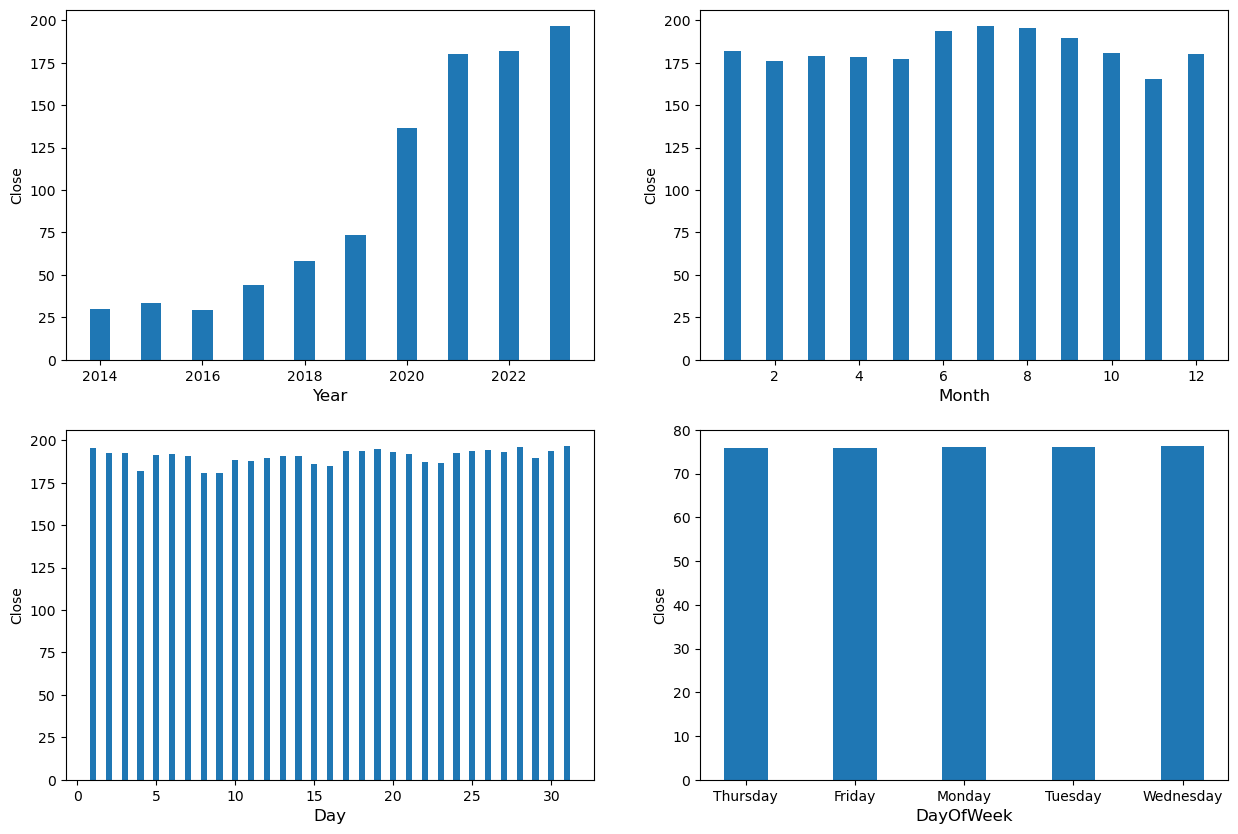

In [9]:
#Trend of the 'Close' variable over time
f, axes = plt.subplots(2, 2, figsize=(15, 10))
#Year and Close
axes[0, 0].bar(df['Year'], df['Close'] , width = 0.4)
axes[0, 0].set_xlabel("Year", fontsize=12)
axes[0, 0].set_ylabel("Close")
#Month and Close
axes[0, 1].bar(df['Month'], df['Close'] , width = 0.4)
axes[0, 1].set_xlabel("Month", fontsize=12)
axes[0, 1].set_ylabel("Close")
#Day and Close
axes[1, 0].bar(df['Day'], df['Close'] , width = 0.4)
axes[1, 0].set_xlabel("Day", fontsize=12)
axes[1, 0].set_ylabel("Close")
#DayOfWeek and Close
axes[1, 1].bar(df['DayOfWeek'].unique(), df.groupby('DayOfWeek')['Close'].mean() , width = 0.4)
axes[1, 1].set_xlabel("DayOfWeek", fontsize=12)
axes[1, 1].set_ylabel("Close")

plt.show()

In [10]:
#Is there any correlation between the variables 'High' and 'Low'?
corr = df['High'].corr(df['Low'])
print(f"\n'High' ve 'Low' fiyatlar arasindaki korelasyon: {corr}")


'High' ve 'Low' fiyatlar arasindaki korelasyon: 0.999810573091547


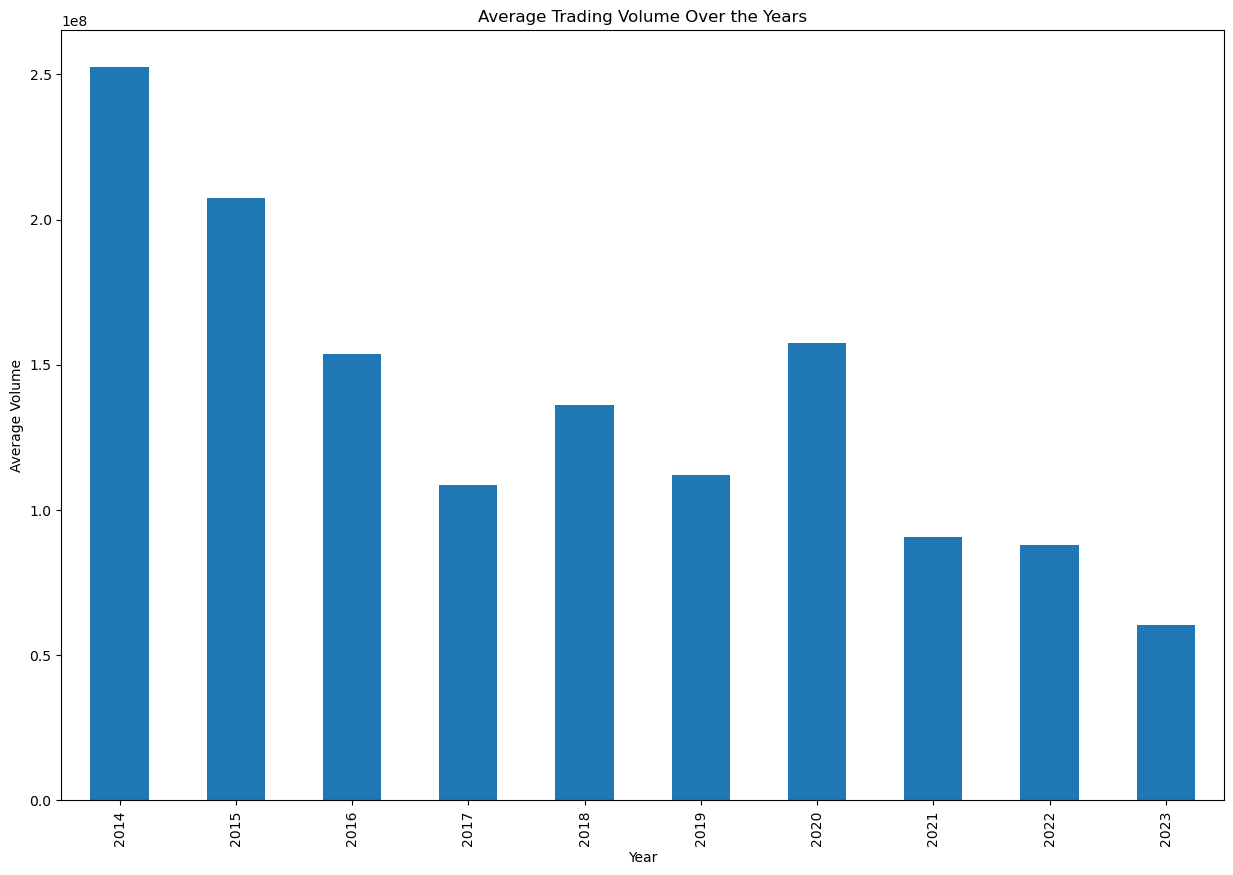

In [11]:
#What is the average transaction volume over the years?
average = df.groupby('Year')['Volume'].mean()
plt.figure(figsize=(15,10))
average.plot(kind='bar')
plt.title('Average Trading Volume Over the Years')
plt.ylabel('Average Volume')
plt.show()

<Axes: xlabel='Open', ylabel='Close'>

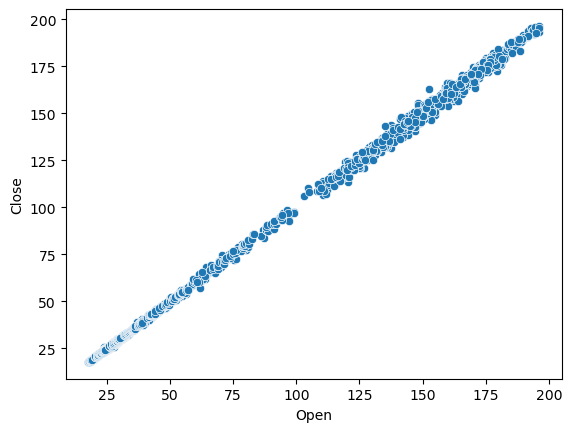

In [12]:
#What is the relationship between the variables 'Open' and 'Close'?
sns.scatterplot(x="Open", y="Close", data=df)

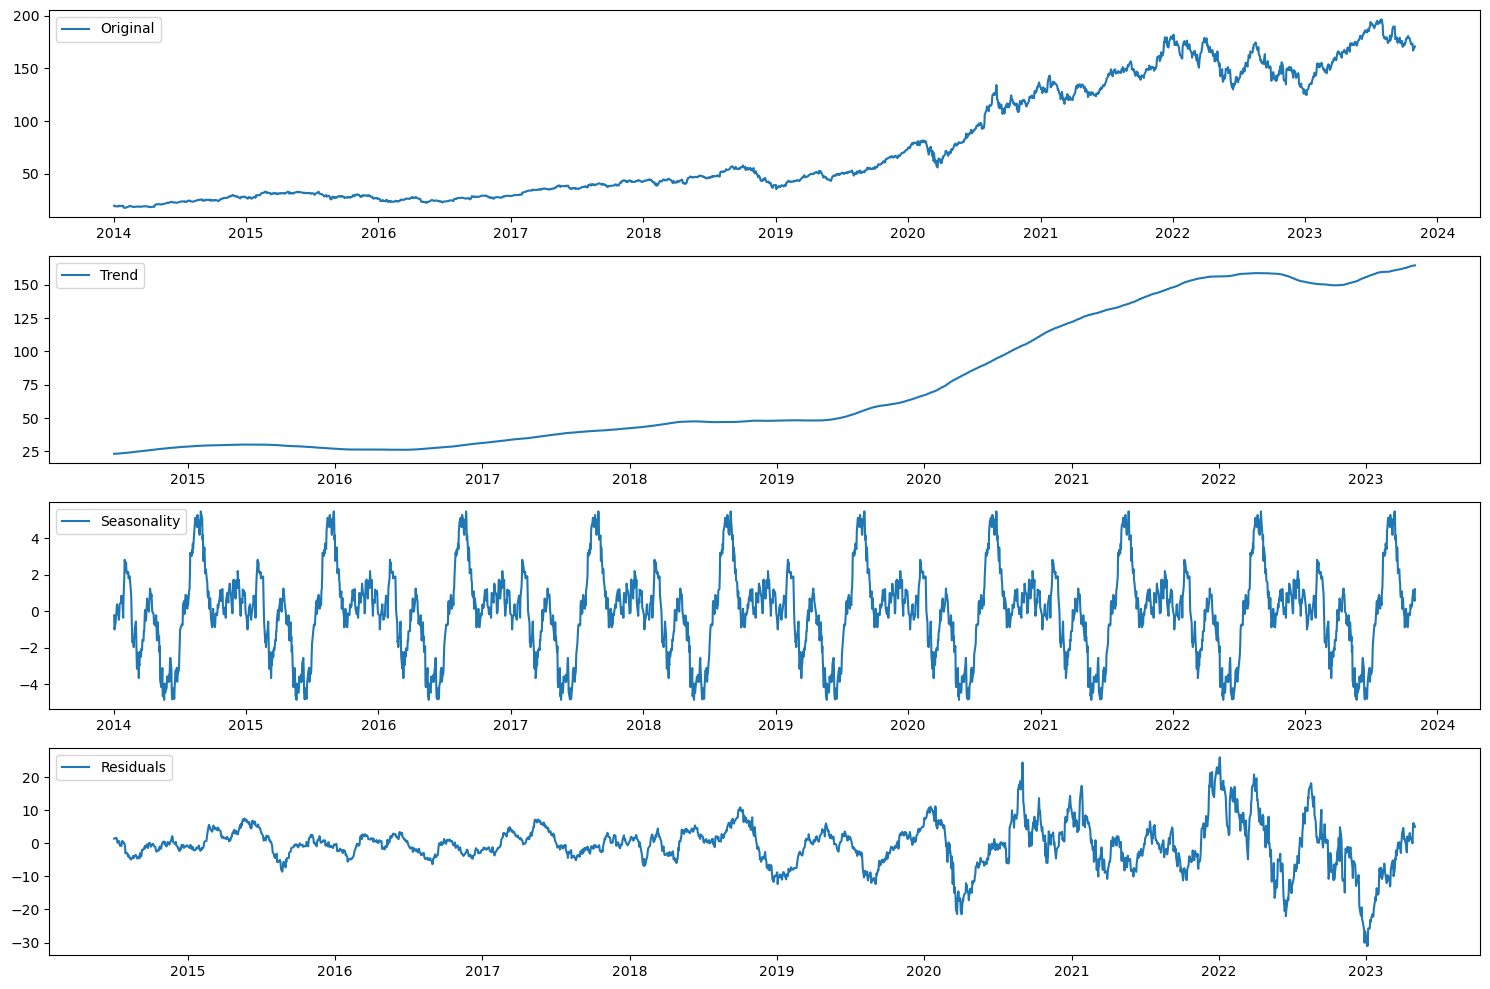

In [13]:
#Is there any noticeable seasonality in stock prices?
from statsmodels.tsa.seasonal import seasonal_decompose

df.set_index('Date', inplace=True)

plt.figure(figsize=(15,10))
decomposition = seasonal_decompose(df['Close'], period=252) #Assuming 252 transactions per year
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(4, 1, 1)
plt.plot(df['Close'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

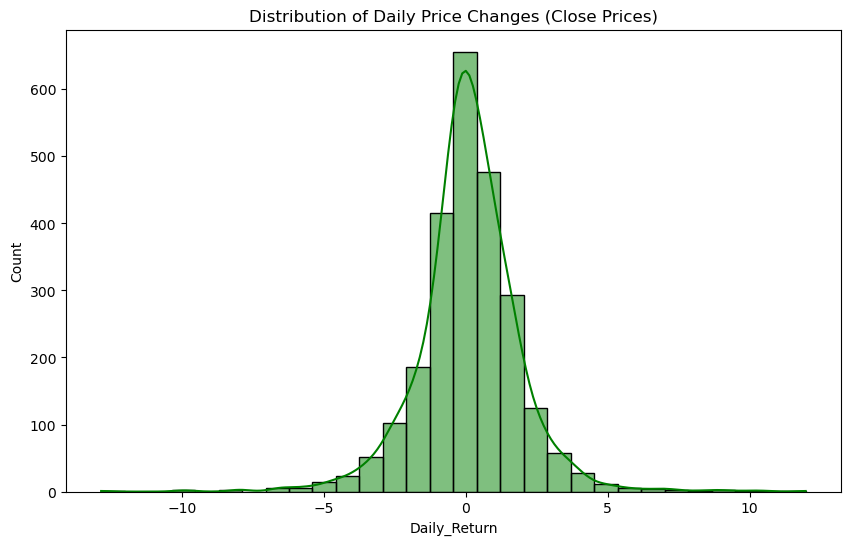

In [14]:
#What is the distribution of daily price changes (percentage change) in 'Close' prices?
df['Daily_Return'] = df['Close'].pct_change()*100
plt.figure(figsize=(10,6))
sns.histplot(df['Daily_Return'].dropna(), bins=30, kde=True, color='green')
plt.title('Distribution of Daily Price Changes (Close Prices)')
plt.show()

### Modelling

In [15]:
data = df['Close']

In [16]:
#Feature Scaling Normalization
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1))
scaled_data

array([[0.01066825],
       [0.00823866],
       [0.00882855],
       ...,
       [0.84193794],
       [0.853528  ],
       [0.85621562]])

In [17]:
out = []
for i in scaled_data:
    out.append(i[0])
scaled_data1 = out
scaled_data1

[0.010668251774569384,
 0.00823865599310368,
 0.008828554069967812,
 0.008050687854883179,
 0.008734575340558118,
 0.007346797851005504,
 0.006630914879726987,
 0.0071888281503886126,
 0.009320479321422312,
 0.011514113736262155,
 0.010892220173794445,
 0.008176662069896465,
 0.009856393025881219,
 0.010344313501934738,
 0.011278152369636293,
 0.009256488350215156,
 0.010142333989511337,
 0.0013437890365482208,
 0.00019396996162143743,
 0.0,
 0.00016397152401781412,
 0.0003499426142383605,
 0.0018017003955970723,
 0.002561582499281012,
 0.00254558475647923,
 0.003979347747036177,
 0.005841045017840454,
 0.007234824330794032,
 0.007226814779992083,
 0.008928545302179527,
 0.00884054703736864,
 0.009240490607413374,
 0.007516771198424241,
 0.0062729733940877636,
 0.005093166560958401,
 0.005553085647408251,
 0.004455275255688895,
 0.0035134268371853766,
 0.00557709294101201,
 0.005291141297980834,
 0.005595087731813761,
 0.006290968184889487,
 0.006514936584114547,
 0.0061929846800787836

In [18]:
train_size = int(len(scaled_data1)* 0.6)
test_size = len(scaled_data1) - train_size
train, test = scaled_data1[0:train_size], scaled_data1[train_size:len(scaled_data1)]
print(len(train), len(test))

1485 990


In [19]:
def create_dataset(dataset, look_back):
    X_data, Y_data = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        X_data.append(a)
        Y_data.append(dataset[i+look_back])
    return np.array(X_data), np.array(Y_data)

In [20]:
look_back = 10
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1474, 10)
(1474,)
(979, 10)
(979,)


In [22]:
#reshape [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [23]:
X_train.shape

(1474, 1, 10)

In [24]:
#Initialising the RNN
model = Sequential()
model.add(LSTM(4, input_shape= (1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=128, epochs=100)

Epoch 1/100
12/12 [==============================] - 3s 3ms/step - loss: 0.0114
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 5/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 8/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 9/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 8.7717e-04
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 7.5553e-04
Epoch 13/100
12/12 [=========

### Prediction

In [25]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([y_train])
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([y_test])

31/31 [==============================] - 0s 929us/step


In [26]:
score_train = math.sqrt(mean_squared_error(y_train[0], train_pred[:, 0]))
print('Train Score: %.2f RMSE' %(score_train))
score_test = math.sqrt(mean_squared_error(y_test[0], test_pred[:, 0]))
print('Test Score: %.2f RMSE' %(score_test))

Train Score: 1.00 RMSE
Test Score: 5.86 RMSE


In [27]:
#graph plotting
train_pred_plot = np.zeros(len(scaled_data1))
train_pred_plot[:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back] = train_pred[:,0]

In [28]:
test_pred_plot = np.zeros(len(scaled_data1), dtype = np.float64)
test_pred_plot[:] = np.nan
test_pred_plot[len(train_pred)+(look_back*2)+1:len(scaled_data1)-1] = test_pred[:,0]

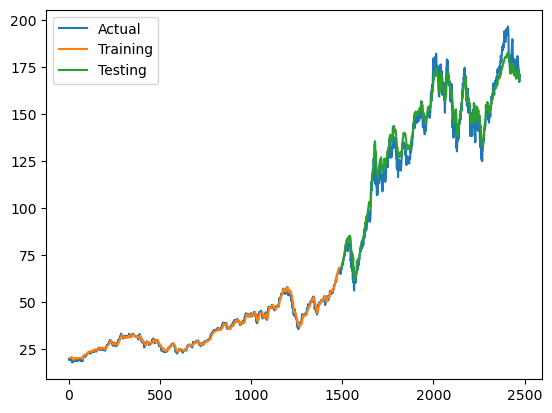

In [29]:
plt.plot(scaler.inverse_transform(scaled_data), label = 'Actual')
plt.plot(train_pred_plot, label = 'Training')
plt.plot(test_pred_plot, label = 'Testing')
plt.legend()
plt.show()